## ELETTRA-30: ID linear optics distortion (analytical)

In [1]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.quadrupole import Quadrupole
from model.library.matrix import Matrix

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling

In [2]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [3]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [4]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Merge drifts

ring.merge()

# Change lattice start

ring.start = "MLL_S01"

# Roll lattice

ring.roll(1)

# Describe

ring.describe

{'Drift': 708, 'BPM': 168, 'Quadrupole': 360, 'Dipole': 156, 'Marker': 12}

In [5]:
# Compute tunes (fractional part)

nux, nuy = tune(ring, [], matched=True, limit=1)

In [6]:
# Compute twiss parameters

ax, bx, ay, by = twiss(ring, [], matched=True, advance=True, full=False).T

axi, *_ = ax
bxi, *_ = bx
ayi, *_ = ay
byi, *_ = by

In [7]:
# Compute phase advances

mux, muy = advance(ring, [], alignment=False, matched=True).T

mux = mux.cumsum(-1)
muy = muy.cumsum(-1)

mux = (mux % mux.max()).roll(1)
muy = (muy % muy.max()).roll(1)

In [8]:
# Define ID model (one kick for each period)
# Note, only the flattened triangular part of the A and B matrices is passed

ca, cb, cc, cd = -0.034441907232402175, -0.04458009513208418, 0.056279356423643276, 0.08037110220505986

A = torch.tensor([[ca, 0.0, 0.0, 0.0],
                  [0.0, cb, 0.0, 0.0],
                  [0.0, 0.0, cc, 0.0], 
                  [0.0, 0.0, 0.0, cd]], dtype=dtype)

ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist())

In [9]:
# Replace marker by ID

ring.replace('MLL_S01', ID)

# Describe

ring.describe

{'Drift': 708,
 'BPM': 168,
 'Quadrupole': 360,
 'Dipole': 156,
 'Marker': 11,
 'Matrix': 1}

In [10]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(ring, [], matched=True, limit=1)

In [11]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(ring, [], matched=True, advance=True, full=False).T

axf, *_ = ax_id
bxf, *_ = bx_id
ayf, *_ = ay_id
byf, *_ = by_id

In [12]:
# Compute phase advances

mux_id, muy_id = advance(ring, [], alignment=False, matched=True).T

mux_id = mux_id.cumsum(-1)
muy_id = muy_id.cumsum(-1)

mux_id = (mux_id % mux_id.max()).roll(1)
muy_id = (muy_id % muy_id.max()).roll(1)

In [13]:
# Tune shifts

print((nux - nux_id))
print((nuy - nuy_id))

tensor(0.0257, dtype=torch.float64)
tensor(-0.0112, dtype=torch.float64)


In [14]:
# Tune shifts (analytical)

Ca, Cb, Cc, Cd = torch.tensor([ca, cb, cc, cd], dtype=torch.complex128)

# Exact

def dnux(ca, cb, ax, bx, nux):
    return nux - torch.arccos(torch.cos(torch.sqrt(ca)*torch.sqrt(cb))*torch.cos(2*torch.pi*nux) - ((bx**2*ca + cb + ax**2*cb)*torch.sin(torch.sqrt(ca)*torch.sqrt(cb))*torch.sin(2 *torch.pi*nux))/(2*bx*torch.sqrt(ca)*torch.sqrt(cb)))/(2*torch.pi)

def dnuy(cc, cd, ay, by, nuy):
    return nuy - torch.arccos(torch.cos(torch.sqrt(cc)*torch.sqrt(cd))*torch.cos(2*torch.pi*nuy) - ((by**2*cc + cd + ay**2*cd)*torch.sin(torch.sqrt(cc)*torch.sqrt(cd))*torch.sin(2 *torch.pi*nuy))/(2*by*torch.sqrt(cc)*torch.sqrt(cd)))/(2*torch.pi)

print(dnux(Ca, Cb, axi, bxi, nux).real)
print(dnuy(Cc, Cd, ayi, byi, nuy).real)
print()

# Approximate

def dnux(ca, cb, ax, bx, nux):
    dnux = 0.0
    dnux -= bx*ca/(4*torch.pi)
    dnux -= (1 + ax**2)*cb/(4*bx*torch.pi)
    dnux -= -(bx**2*ca**2*(1/torch.tan(2*torch.pi*nux)))/(16*torch.pi)
    dnux -= -((ax**2 - 1)*ca*cb*(1/torch.tan(2*torch.pi*nux)))/(8*torch.pi)
    dnux -= -((1 + ax**2)**2*cb**2*(1/torch.tan(2*torch.pi*nux)))/(16*bx**2*torch.pi)
    return dnux

def dnuy(cc, cd, ay, by, nuy):
    dnuy = 0.0
    dnuy -= by*cc/(4*torch.pi)
    dnuy -= (1 + ay**2)*cd/(4*by*torch.pi)
    dnuy -= -(by**2*cc**2*(1/torch.tan(2*torch.pi*nuy)))/(16*torch.pi)
    dnuy -= -((ay**2 - 1)*cc*cd*(1/torch.tan(2*torch.pi*nuy)))/(8*torch.pi)
    dnuy -= -((1 + ay**2)**2*cd**2*(1/torch.tan(2*torch.pi*nuy)))/(16*by**2*torch.pi)
    return dnuy

print(dnux(Ca, Cb, axi, bxi, nux).real)
print(dnuy(Cc, Cd, ayi, byi, nuy).real)

tensor(0.0257, dtype=torch.float64)
tensor(-0.0112, dtype=torch.float64)

tensor(0.0255, dtype=torch.float64)
tensor(-0.0112, dtype=torch.float64)


In [15]:
# Twiss parameters at ID

Ca, Cb, Cc, Cd = torch.tensor([ca, cb, cc, cd], dtype=torch.complex128)

# Exact

def csx(ca, cb, ax, bx, nux):
    axf = ((2*ax*torch.cos(torch.sqrt(ca)*torch.sqrt(cb)) + ((bx**2*ca - (1 + ax**2)*cb) * torch.sin(torch.sqrt(ca)*torch.sqrt(cb)))/(bx*torch.sqrt(ca)*torch.sqrt(cb)))* torch.sin(2*nux*torch.pi)) / (2*torch.sqrt(1 - (torch.cos(torch.sqrt(ca)*torch.sqrt(cb))*torch.cos(2*nux*torch.pi)- ((bx**2*ca + cb + ax**2*cb)* torch.sin(torch.sqrt(ca)*torch.sqrt(cb))* torch.sin(2*nux*torch.pi))/(2*bx*torch.sqrt(ca)*torch.sqrt(cb)))**2))
    bxf = (bx*torch.cos(torch.sqrt(ca)*torch.sqrt(cb))*torch.sin(2*nux*torch.pi)+ (torch.sqrt(cb)*torch.sin(torch.sqrt(ca)*torch.sqrt(cb))* (torch.cos(2*nux*torch.pi) - ax*torch.sin(2*nux*torch.pi)))/torch.sqrt(ca)) / torch.sqrt(1 - (torch.cos(torch.sqrt(ca)*torch.sqrt(cb))*torch.cos(2*nux*torch.pi)- ((bx**2*ca + cb + ax**2*cb)* torch.sin(torch.sqrt(ca)*torch.sqrt(cb))* torch.sin(2*nux*torch.pi))/(2*bx*torch.sqrt(ca)*torch.sqrt(cb)))**2)
    return torch.stack([axf, bxf]).real

def csy(cc, cd, ay, by, nuy):
    ayf = ((2*ay*torch.cos(torch.sqrt(cc)*torch.sqrt(cd)) + ((by**2*cc - (1 + ay**2)*cd) * torch.sin(torch.sqrt(cc)*torch.sqrt(cd)))/(by*torch.sqrt(cc)*torch.sqrt(cd))) * torch.sin(2*nuy*torch.pi)) / (2*torch.sqrt(1 - (torch.cos(torch.sqrt(cc)*torch.sqrt(cd))*torch.cos(2*nuy*torch.pi)- ((by**2*cc + cd + ay**2*cd)* torch.sin(torch.sqrt(cc)*torch.sqrt(cd))* torch.sin(2*nuy*torch.pi))/(2*by*torch.sqrt(cc)*torch.sqrt(cd)))**2))
    byf = (by*torch.cos(torch.sqrt(cc)*torch.sqrt(cd))*torch.sin(2*nuy*torch.pi) + (torch.sqrt(cd)*torch.sin(torch.sqrt(cc)*torch.sqrt(cd)) * (torch.cos(2*nuy*torch.pi) - ay*torch.sin(2*nuy*torch.pi)))/torch.sqrt(cc)) / torch.sqrt(1 - (torch.cos(torch.sqrt(cc)*torch.sqrt(cd))*torch.cos(2*nuy*torch.pi) - ((by**2*cc + cd + ay**2*cd) * torch.sin(torch.sqrt(cc)*torch.sqrt(cd)) * torch.sin(2*nuy*torch.pi))/(2*by*torch.sqrt(cc)*torch.sqrt(cd)))**2)
    return torch.stack([ayf, byf]).real

print(torch.stack([axf, bxf]))
print(csx(Ca, Cb, axi, bxi, nux))
print()

print(torch.stack([ayf, byf]))
print(csy(Cc, Cd, ayi, byi, nuy))
print()

# Approximate

def csx(ca, cb, ax, bx, nux):
    bxf = 0.0
    bxf += -0.5 * bx**2 * ca * (1.0 / torch.tan(2 * nux * torch.pi))
    bxf += 0.25 * cb * (-4 * ax - (-1 + ax**2) * (1.0 / torch.tan(nux * torch.pi)) + (-1 + ax**2) * torch.tan(nux * torch.pi))
    bxf += 0.125 * bx**3 * ca**2 * (2 + torch.cos(4 * nux * torch.pi)) * (1.0 / torch.sin(2 * nux * torch.pi))**2
    bxf += 0.25 * bx * ca * cb * (1.0 / torch.sin(2 * nux * torch.pi))**2 * (-1 + 2 * ax**2 + ax * (ax * torch.cos(4 * nux * torch.pi) + torch.sin(4 * nux * torch.pi)))
    bxf += ((1 + ax**2) * cb**2 * (1.0 / torch.sin(2 * nux * torch.pi))**2 * ((-1 + ax**2) * torch.cos(4 * nux * torch.pi) + 2 * ax * (ax + torch.sin(4 * nux * torch.pi)))) / (8 * bx)
    return bx + bxf.real

def csy(cc, cd, ay, by, nuy):
    byf = 0.0
    byf += -0.5 * by**2 * cc * (1.0 / torch.tan(2 * nuy * torch.pi))
    byf += 0.25 * cd * (-4 * ay - (-1 + ay**2) * (1.0 / torch.tan(nuy * torch.pi)) + (-1 + ay**2) * torch.tan(nuy * torch.pi))
    byf += 0.125 * by**3 * cc**2 * (2 + torch.cos(4 * nuy * torch.pi)) * (1.0 / torch.sin(2 * nuy * torch.pi))**2
    byf += 0.25 * by * cc * cd * (1.0 / torch.sin(2 * nuy * torch.pi))**2 * (-1 + 2 * ay**2 + ay * (ay * torch.cos(4 * nuy * torch.pi) + torch.sin(4 * nuy * torch.pi)))
    byf += ((1 + ay**2) * cd**2 * (1.0 / torch.sin(2 * nuy * torch.pi))**2 * ((-1 + ay**2) * torch.cos(4 * nuy * torch.pi) + 2 * ay * (ay + torch.sin(4 * nuy * torch.pi)))) / (8 * by)
    return by + byf.real

print(bxf)
print(csx(Ca, Cb, axi, bxi, nux))
print()

print(byf)
print(csy(Cc, Cd, ayi, byi, nuy))
print()

tensor([-0.1538,  9.0725], dtype=torch.float64)
tensor([-0.1538,  9.0725], dtype=torch.float64)

tensor([0.0208, 1.6190], dtype=torch.float64)
tensor([0.0208, 1.6190], dtype=torch.float64)

tensor(9.0725, dtype=torch.float64)
tensor(9.0905, dtype=torch.float64)

tensor(1.6190, dtype=torch.float64)
tensor(1.6191, dtype=torch.float64)



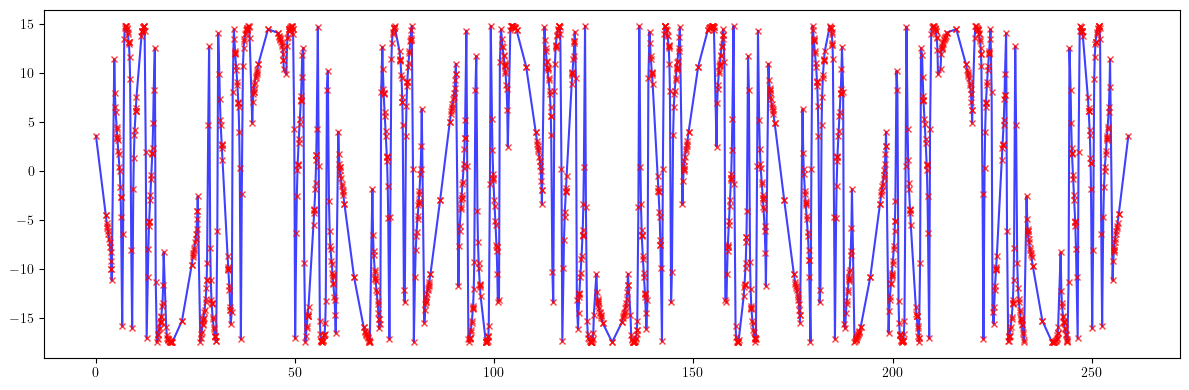

tensor(11.5210, dtype=torch.float64)
tensor(11.5210, dtype=torch.float64)


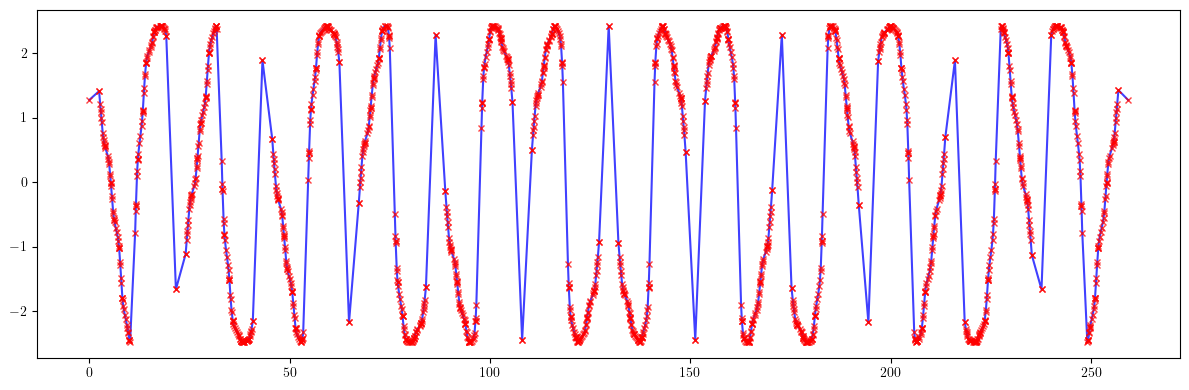

tensor(1.8491, dtype=torch.float64)
tensor(1.8491, dtype=torch.float64)


In [16]:
# Beta beating (exact)

Ca, Cb, Cc, Cd = torch.tensor([ca, cb, cc, cd], dtype=torch.complex128)

def bbx(ca, cb, nux, ax, bx, axs, bxs, mux):
    phi = torch.sqrt(ca) * torch.sqrt(cb)
    bxf = (bxs * (torch.sqrt(cb) * torch.cos(nux * torch.pi)**2 * torch.sin(phi) - torch.sqrt(cb) * torch.sin(phi) * torch.sin(nux * torch.pi) * (2 * ax * torch.cos(nux * torch.pi) + torch.sin(nux * torch.pi)) + bx * torch.sqrt(ca) * torch.cos(phi) * torch.sin(2 * nux * torch.pi)) * (-2 * ax * cb * torch.cos(phi + 2 * mux - 2 * nux * torch.pi) + 2 * ax * cb * torch.cos(phi - 2 * mux + 2 * nux * torch.pi) + bx**2 * ca * torch.sin(phi - 2 * nux * torch.pi) - 2 * bx * torch.sqrt(ca) * torch.sqrt(cb) * torch.sin(phi - 2 * nux * torch.pi) + cb * torch.sin(phi - 2 * nux * torch.pi) + ax**2 * cb * torch.sin(phi - 2 * nux * torch.pi) - bx**2 * ca * torch.sin(phi + 2 * mux - 2 * nux * torch.pi) + cb * torch.sin(phi + 2 * mux - 2 * nux * torch.pi) - ax**2 * cb * torch.sin(phi + 2 * mux - 2 * nux * torch.pi) + bx**2 * ca * torch.sin(phi + 2 * nux * torch.pi) + 2 * bx * torch.sqrt(ca) * torch.sqrt(cb) * torch.sin(phi + 2 * nux * torch.pi) + cb * torch.sin(phi + 2 * nux * torch.pi) + ax**2 * cb * torch.sin(phi + 2 * nux * torch.pi) - bx**2 * ca * torch.sin(phi - 2 * mux + 2 * nux * torch.pi) + cb * torch.sin(phi - 2 * mux + 2 * nux * torch.pi) - ax**2 * cb * torch.sin(phi - 2 * mux + 2 * nux * torch.pi))) / (2 * bx * torch.sqrt(ca) * torch.sqrt(cb) * (torch.sqrt(cb) * torch.cos(2 * nux * torch.pi) * torch.sin(phi) + (bx * torch.sqrt(ca) * torch.cos(phi) - ax * torch.sqrt(cb) * torch.sin(phi)) * torch.sin(2 * nux * torch.pi)) * torch.sqrt(4 - 4 * torch.cos(phi)**2 * torch.cos(2 * nux * torch.pi)**2 - ((bx**2 * ca + cb + ax**2 * cb)**2 * torch.sin(phi)**2 * torch.sin(2 * nux * torch.pi)**2) / (bx**2 * ca * cb) + ((bx**2 * ca + cb + ax**2 * cb) * torch.sin(2 * phi) * torch.sin(4 * nux * torch.pi)) / (bx * torch.sqrt(ca) * torch.sqrt(cb))))
    return (100*(bxf - bxs)/bxs).real

def bby(cc, cd, nuy, ay, by, ays, bys, muy):
    phi = torch.sqrt(cc) * torch.sqrt(cd)
    byf = (bys * (torch.sqrt(cd) * torch.cos(nuy * torch.pi)**2 * torch.sin(phi) - torch.sqrt(cd) * torch.sin(phi) * torch.sin(nuy * torch.pi) * (2 * ay * torch.cos(nuy * torch.pi) + torch.sin(nuy * torch.pi)) + by * torch.sqrt(cc) * torch.cos(phi) * torch.sin(2 * nuy * torch.pi)) * (-2 * ay * cd * torch.cos(phi + 2 * muy - 2 * nuy * torch.pi) + 2 * ay * cd * torch.cos(phi - 2 * muy + 2 * nuy * torch.pi) + by**2 * cc * torch.sin(phi - 2 * nuy * torch.pi) - 2 * by * torch.sqrt(cc) * torch.sqrt(cd) * torch.sin(phi - 2 * nuy * torch.pi) + cd * torch.sin(phi - 2 * nuy * torch.pi) + ay**2 * cd * torch.sin(phi - 2 * nuy * torch.pi) - by**2 * cc * torch.sin(phi + 2 * muy - 2 * nuy * torch.pi) + cd * torch.sin(phi + 2 * muy - 2 * nuy * torch.pi) - ay**2 * cd * torch.sin(phi + 2 * muy - 2 * nuy * torch.pi) + by**2 * cc * torch.sin(phi + 2 * nuy * torch.pi) + 2 * by * torch.sqrt(cc) * torch.sqrt(cd) * torch.sin(phi + 2 * nuy * torch.pi) + cd * torch.sin(phi + 2 * nuy * torch.pi) + ay**2 * cd * torch.sin(phi + 2 * nuy * torch.pi) - by**2 * cc * torch.sin(phi - 2 * muy + 2 * nuy * torch.pi) + cd * torch.sin(phi - 2 * muy + 2 * nuy * torch.pi) - ay**2 * cd * torch.sin(phi - 2 * muy + 2 * nuy * torch.pi))) / (2 * by * torch.sqrt(cc) * torch.sqrt(cd) * (torch.sqrt(cd) * torch.cos(2 * nuy * torch.pi) * torch.sin(phi) + (by * torch.sqrt(cc) * torch.cos(phi) - ay * torch.sqrt(cd) * torch.sin(phi)) * torch.sin(2 * nuy * torch.pi)) * torch.sqrt(4 - 4 * torch.cos(phi)**2 * torch.cos(2 * nuy * torch.pi)**2 - ((by**2 * cc + cd + ay**2 * cd)**2 * torch.sin(phi)**2 * torch.sin(2 * nuy * torch.pi)**2) / (by**2 * cc * cd) + ((by**2 * cc + cd + ay**2 * cd) * torch.sin(2 * phi) * torch.sin(4 * nuy * torch.pi)) / (by * torch.sqrt(cc) * torch.sqrt(cd))))
    return (100*(byf - bys)/bys).real

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', ms=0, color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), -bbx(Ca, Cb, nux, axi, bxi, ax, bx, mux), fmt=' ', marker='x', ms=5, color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print((bbx(Ca, Cb, nux, axi, bxi, ax, bx, mux)**2).mean().sqrt())

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', ms=0, color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), -bby(Cc, Cd, nuy, ayi, byi, ay, by, muy), fmt=' ', marker='x', ms=5, color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((by - by_id)/by)**2).mean().sqrt())
print((bby(Cc, Cd, nuy, ayi, byi, ay, by, muy)**2).mean().sqrt())

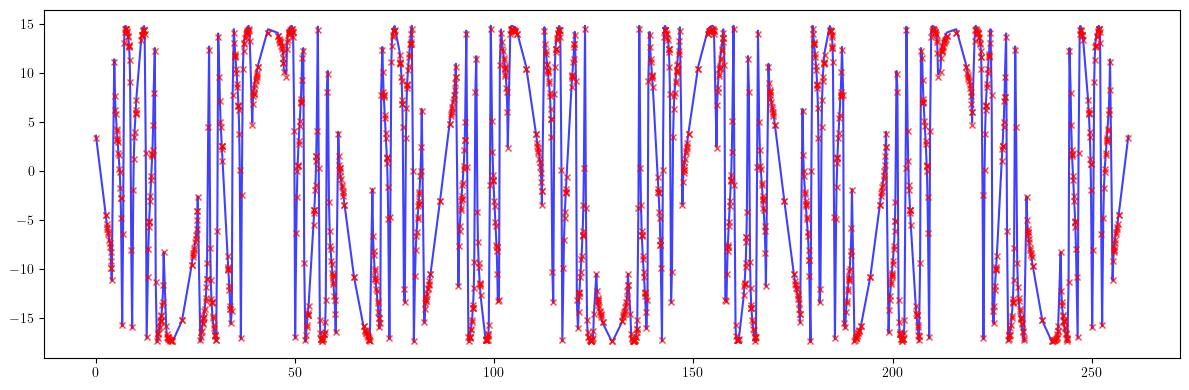

tensor(11.5210, dtype=torch.float64)
tensor(11.3530, dtype=torch.float64)


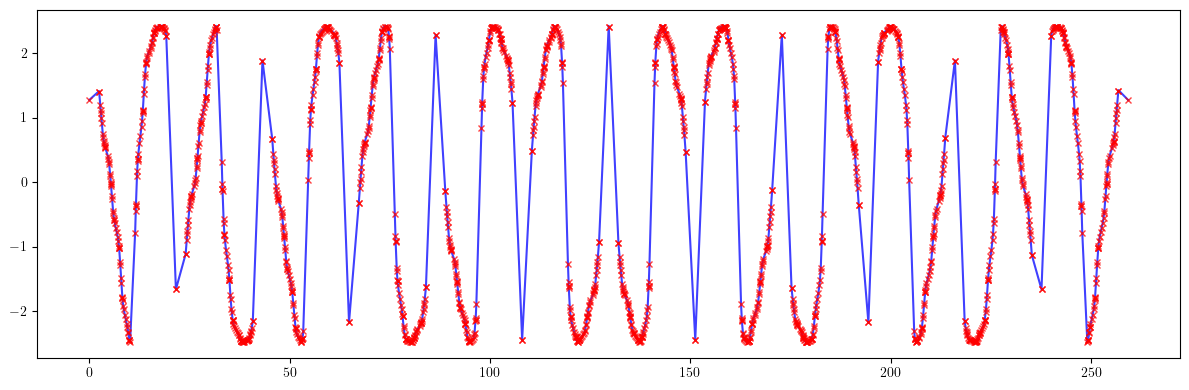

tensor(1.8491, dtype=torch.float64)
tensor(1.8422, dtype=torch.float64)


In [17]:
# Beta beating (approximate)

Ca, Cb, Cc, Cd = torch.tensor([ca, cb, cc, cd], dtype=torch.complex128)

def bbx(ca, cb, nux, ax, bx, axs, bxs, mux):
    bxf = 0.0
    bxf += -0.5 * bx * bxs * ca * torch.cos(2 * (mux - nux * torch.pi)) * (1.0 / torch.sin(2 * nux * torch.pi))
    bxf += -(bxs * cb * (1.0 / torch.sin(2 * nux * torch.pi)) * ((-1 + ax**2) * torch.cos(2 * (mux - nux * torch.pi)) - 2 * ax * torch.sin(2 * (mux - nux * torch.pi))) / (2 * bx))
    bxf += 0.125 * bx**2 * bxs * ca**2 * (1 + torch.cos(2 * mux) + torch.cos(2 * (mux - 2 * nux * torch.pi))) * (1.0 / torch.sin(2 * nux * torch.pi))**2
    bxf += 0.25 * bxs * ca * cb * (1.0 / torch.sin(2 * nux * torch.pi))**2 * (-1 + ax**2 + 2 * ax * torch.cos(2 * nux * torch.pi) * (ax * torch.cos(2 * (mux - nux * torch.pi)) - torch.sin(2 * (mux - nux * torch.pi))))
    bxf += ((1 + ax**2) * bxs * cb**2 * (1.0 / torch.sin(2 * nux * torch.pi))**2 * (1 + ax**2 + (-1 + ax**2) * torch.cos(2 * mux) + (-1 + ax**2) * torch.cos(2 * (mux - 2 * nux * torch.pi)) - 4 * ax * torch.cos(2 * nux * torch.pi) * torch.sin(2 * (mux - nux * torch.pi)))) / (8 * bx**2)
    bxf += bxs
    return (100*(bxf - bxs)/bxs).real

def bby(cc, cd, nuy, ay, by, ays, bys, muy):
    byf = 0.0
    byf += -0.5 * by * bys * cc * torch.cos(2 * (muy - nuy * torch.pi)) * (1.0 / torch.sin(2 * nuy * torch.pi))
    byf += -(bys * cd * (1.0 / torch.sin(2 * nuy * torch.pi)) * ((-1 + ay**2) * torch.cos(2 * (muy - nuy * torch.pi)) - 2 * ay * torch.sin(2 * (muy - nuy * torch.pi))) / (2 * by))
    byf += 0.125 * by**2 * bys * cc**2 * (1 + torch.cos(2 * muy) + torch.cos(2 * (muy - 2 * nuy * torch.pi))) * (1.0 / torch.sin(2 * nuy * torch.pi))**2
    byf += 0.25 * bys * cc * cd * (1.0 / torch.sin(2 * nuy * torch.pi))**2 * (-1 + ay**2 + 2 * ay * torch.cos(2 * nuy * torch.pi) * (ay * torch.cos(2 * (muy - nuy * torch.pi)) - torch.sin(2 * (muy - nuy * torch.pi))))
    byf += ((1 + ay**2) * bys * cd**2 * (1.0 / torch.sin(2 * nuy * torch.pi))**2 * (1 + ay**2 + (-1 + ay**2) * torch.cos(2 * muy) + (-1 + ay**2) * torch.cos(2 * (muy - 2 * nuy * torch.pi)) - 4 * ay * torch.cos(2 * nuy * torch.pi) * torch.sin(2 * (muy - nuy * torch.pi)))) / (8 * by**2)
    byf += bys
    return (100*(byf - bys)/bys).real

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', ms=0, color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), -bbx(Ca, Cb, nux, axi, bxi, ax, bx, mux), fmt=' ', marker='x', ms=5, color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print((bbx(Ca, Cb, nux, axi, bxi, ax, bx, mux)**2).mean().sqrt())

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', ms=0, color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), -bby(Cc, Cd, nuy, ayi, byi, ay, by, muy), fmt=' ', marker='x', ms=5, color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((by - by_id)/by)**2).mean().sqrt())
print((bby(Cc, Cd, nuy, ayi, byi, ay, by, muy)**2).mean().sqrt())

In [18]:
# Relations between focusing parametes (cx and cy) for one period and main diagonal up to second order in cx and cy

def diagonal(np, lp, cx, cy):
    cx, cy = -cx, -cy
    ca = cx*np + (1.0/6.0)*cx**2*lp*(np - np**3)
    cb = (1.0/12.0)*cx*lp**2*np*(-1 + np**2)
    cc = cy*np + (1.0/6.0)*cy**2*lp*(np - np**3)
    cd = (1.0/12.0)*cy*lp**2*np*(-1 + np**2)
    return torch.stack([ca, cb, cc, cd])

np = 40
lp = 0.10036
cx = torch.tensor(+0.0008418142893213273, dtype=dtype)
cy = torch.tensor(-0.0014623657005811024, dtype=dtype)

print(torch.tensor([ca, cb, cc, cd], dtype=dtype))
print(diagonal(np, lp, cx, cy))
print()

tensor([-0.0344, -0.0446,  0.0563,  0.0804], dtype=torch.float64)
tensor([-0.0344, -0.0452,  0.0562,  0.0785], dtype=torch.float64)

